In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
#Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


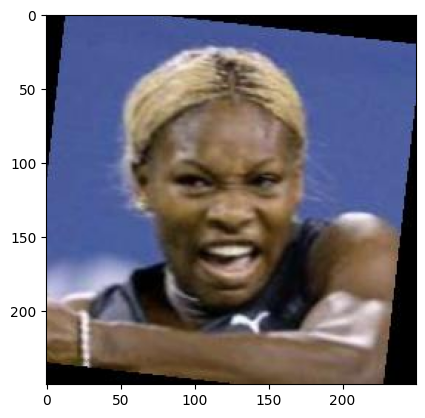

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Autoencoders (AEs):**
- **Applications:** Primarily used for dimensionality reduction, feature learning, and data compression.
- **Architecture:** Encoder-decoder structure without a probabilistic approach to the latent space.
- **Loss Function:** Typically uses a reconstruction loss like mean squared error (MSE).

**Variational Autoencoders (VAEs):**
- **Applications:** Extends AEs for generative tasks, capable of generating diverse and realistic samples.
- **Architecture:** Encoder-decoder structure with a probabilistic latent space, modeling it as a probability distribution.
- **Loss Function:** Combines a reconstruction loss with a regularization term (KL divergence) to shape the latent space distribution.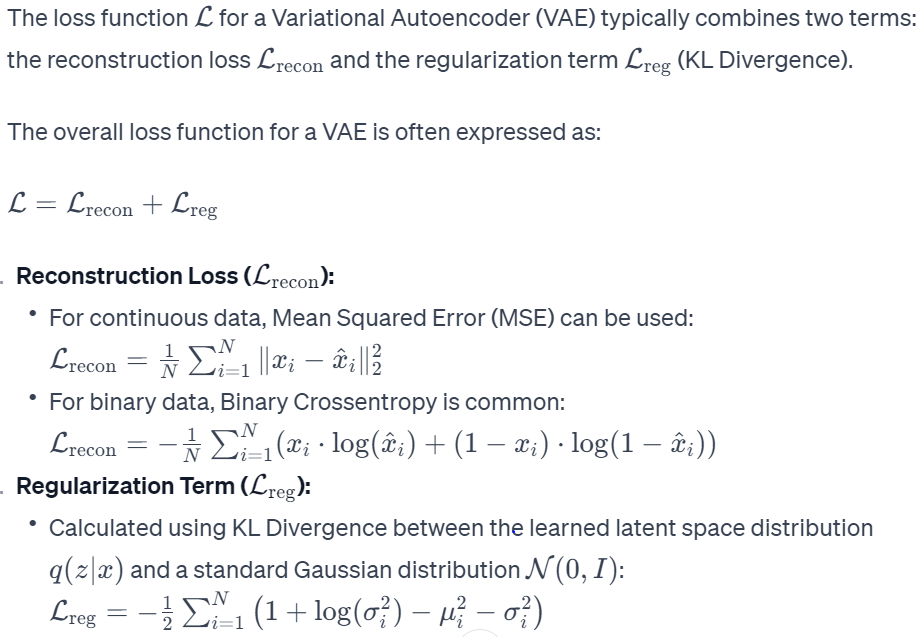

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dims=20, image_size=(3, 250, 250)):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Additional layer
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dims)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dims)

        # Decoder
        self.decoder_input = nn.Linear(latent_dims, 128 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

        # Set image size for reshaping
        self.image_size = image_size

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(h1.size(0), -1)
        return self.fc_mu(h1), self.fc_logvar(h1)

    def decode(self, z):
        h3 = self.decoder_input(z)
        h3 = h3.view(h3.size(0), 128, 16, 16)  # Adjust dimensions based on the added layer
        return self.decoder(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

To generate new samples in the latent space of a Variational Autoencoder (VAE):

1. **Sample Latent Vector:**
   - Sample a latent vector (z) from a Gaussian distribution with mean (mu) and variance (sigma^2) learned by the VAE's encoder, using the reparameterization trick:

   \[ z = mu + epsilon . sigma, ]

   where (epsilon) is sampled from a standard Gaussian distribution.

2. **Decode Latent Vector:**
   - Pass the sampled latent vector (z) through the VAE's decoder to generate a new sample in the data space.

This process allows for the generation of diverse and realistic samples by exploring the learned latent space of the VAE.

In [30]:
# Instantiate the VAE model
vae = VAE().to(device)

# Number of batches to process
num_batches = 5

for batch_idx in range(num_batches):
    # Load one batch of images
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Reshape the images if necessary (the VAE expects [batch_size, 3, 250, 250])
    # If your images are not of this size, you might need to resize them

    # Forward pass through the model
    decoded, mu, logvar = vae(images)

    # Reparameterize to get latent space samples
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Print the shapes
    print(f"Batch {batch_idx + 1}:")
    print("Shape of mu:", mu.shape)
    print("Shape of logvar:", logvar.shape)
    print("Shape of latent space samples (z):", z.shape)
    print("Shape of decoded images:", decoded.shape)
    print("=" * 30)


Shape of mu: torch.Size([32, 20])
Shape of logvar: torch.Size([32, 20])
Shape of latent space samples (z): torch.Size([32, 20])
Shape of decoded images: torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


**Loss Function:**

In the context of a Variational Autoencoder (VAE), the loss function typically consists of two terms:

1. **Reconstruction Loss (Data Fidelity Term):**
   - **Goal:** Ensures that the generated output is close to the original input.
   - **Term:** Often measured by a pixel-wise loss such as Mean Squared Error (MSE) for continuous data or Binary Crossentropy for binary data.
   - **Explanation:** This term encourages the VAE to reconstruct input data accurately, capturing its essential features.

2. **Regularization Term (KL Divergence):**
   - **Goal:** Shapes the distribution of the latent space, making it close to a standard Gaussian distribution.
   - **Term:** Calculated using the Kullback-Leibler (KL) Divergence between the learned distribution of the latent space and a standard Gaussian distribution.
   - **Explanation:** The regularization term prevents overfitting and ensures that the latent space is continuous and well-structured, allowing for smooth generation of new samples.

**Total Number of Parameters:**

To print the total number of parameters in the model, you can use the following Python code:

```python
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')
```

This code iterates through all the parameters in the model and calculates the total number of parameters.

Understanding the loss function components and their goals is crucial:
- The reconstruction loss ensures accurate reconstruction of input data.
- The regularization term shapes the latent space distribution for effective generative modeling.


In the provided code, a Variational Autoencoder (VAE) is being trained using binary cross-entropy (BCE) as the reconstruction loss and the Kullback-Leibler (KL) divergence as the regularization term.


Reconstruction Loss (BCE):

Goal: Ensures that the generated output (recon_x) is close to the original input (x).

Explanation: BCE measures the pixel-wise difference between the reconstructed output and the original input. It penalizes deviations from the true data distribution, promoting accurate reconstruction.

Regularization Term (Kullback-Leibler Divergence):

Goal: Shapes the distribution of the latent space, making it close to a standard Gaussian distribution.
Explanation: The KL divergence term encourages the learned distribution of the latent space (characterized by mean mu and log variance logvar) to resemble a standard Gaussian distribution. It regularizes the latent space, preventing it from becoming overly complex and facilitating smoother generation of new samples.

Total Loss:

The total loss is the sum of the reconstruction loss and the regularization term:

total_loss = BCE + KLD
Goal: Balances the accuracy of reconstruction with the regularization of the latent space.


Explanation: By combining BCE and KLD, the model aims to reconstruct input data accurately while maintaining a well-structured and continuous latent space. This balance is crucial for effective generative modeling in VAEs.
During training, the optimizer minimizes this composite loss, guiding the VAE to learn a latent space representation that facilitates both accurate reconstruction and meaningful generative capabilities.

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(vae):,} trainable parameters.')

The model has 4,071,867 trainable parameters.


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

If the loss is not decreasing during training:

1. **Adjust Learning Rate:**
   - Reduce the learning rate to help the model converge more gradually and avoid overshooting the minimum.

2. **Check Model Complexity:**
   - Evaluate if the model is too complex for the given data. Simplify the architecture if needed.

3. **Data Issues:**
   - Inspect and preprocess the data; ensure it is clean, well-scaled, and representative.

4. **Regularization:**
   - Introduce regularization techniques (e.g., dropout, weight decay) to prevent overfitting.

5. **Initialization:**
   - Reconsider weight initialization strategies; poor initialization can impede convergence.

6. **Monitor Gradients:**
   - Check gradients during training to identify potential vanishing or exploding gradient issues.

7. **Architecture Debugging:**
   - Verify network architecture, layer configurations, and loss function compatibility.

8. **Debug Code:**
   - Review the training code for errors, ensuring correct implementation of the model and training loop.

9. **Increase Epochs:**
   - Allow more training epochs; the model may need additional time to converge.

10. **Model Evaluation:**
    - Regularly assess model performance on validation data to detect issues early.

Implementing these steps can help troubleshoot and address non-decreasing loss during training.

In [34]:
# Number of epochs
num_epochs = 50

# Define the optimizer and loss function
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 3 * 250 * 250), x.view(-1, 3 * 250 * 250), reduction='sum')

    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = vae(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss: .4f}")


Epoch [1/50], Loss:  98889.4166
Epoch [2/50], Loss:  98279.6158
Epoch [3/50], Loss:  97986.4161
Epoch [4/50], Loss:  97771.6547
Epoch [5/50], Loss:  97606.7512
Epoch [6/50], Loss:  97463.4679
Epoch [7/50], Loss:  97347.0373
Epoch [8/50], Loss:  97245.6187
Epoch [9/50], Loss:  97148.4656
Epoch [10/50], Loss:  97056.8407
Epoch [11/50], Loss:  96983.3419
Epoch [12/50], Loss:  96893.7715
Epoch [13/50], Loss:  96828.5035
Epoch [14/50], Loss:  96765.4129
Epoch [15/50], Loss:  96716.0729
Epoch [16/50], Loss:  96641.3190
Epoch [17/50], Loss:  96579.4571
Epoch [18/50], Loss:  96523.7631
Epoch [19/50], Loss:  96457.4069
Epoch [20/50], Loss:  96402.1996
Epoch [21/50], Loss:  96361.8945
Epoch [22/50], Loss:  96310.1290
Epoch [23/50], Loss:  96224.7511
Epoch [24/50], Loss:  96102.5437
Epoch [25/50], Loss:  95987.1542
Epoch [26/50], Loss:  95882.9825
Epoch [27/50], Loss:  95811.4787
Epoch [28/50], Loss:  95747.5708
Epoch [29/50], Loss:  95688.6737
Epoch [30/50], Loss:  95643.4175
Epoch [31/50], Loss

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

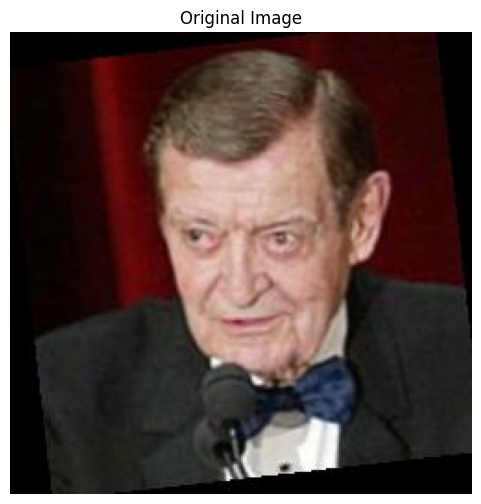

In [76]:
# Set VAE to evaluation mode
vae.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Plot the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')
    plt.show()


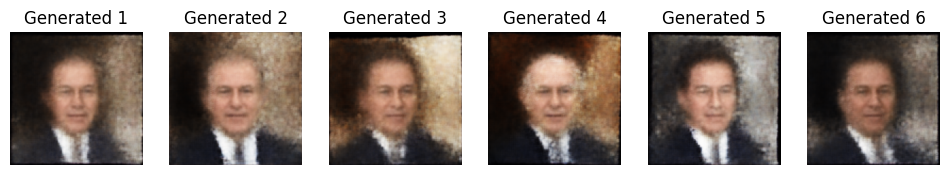

In [85]:
# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encode the image to get the latent space representation
    mu, logvar = vae.encode(original_image)

    # Reparameterize to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Generate and plot 10 similar images with amplified variations
    plt.figure(figsize=(12, 6))

    for i in range(1, 7):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor

        # Decode the varied latent vector
        generated_image_varied = vae.decode(z_varied)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Generated {i}")
        plt.axis('off')

    plt.show()